# Clasificación de vinos españoles
Este notebook realiza la clasificación de un dataset de vinos españoles usando técnicas de machine learning.

## Secciones:
1. Importar librerías necesarias
2. Cargar y explorar el dataset de vinos españoles
3. Preprocesamiento de datos
4. Visualización de datos
5. Dividir el dataset en entrenamiento y prueba
6. Entrenar un modelo de clasificación
7. Evaluar el modelo
8. Realizar predicciones con nuevos datos

In [2]:
%pip install pandas

# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

Note: you may need to restart the kernel to use updated packages.


In [3]:
# 2. Cargar y explorar el dataset de vinos españoles
df = pd.read_csv('wines_SPA.csv')
print('Shape:', df.shape)
print('Columnas:', df.columns.tolist())
df.head()

Shape: (7500, 11)
Columnas: ['winery', 'wine', 'year', 'rating', 'num_reviews', 'country', 'region', 'price', 'type', 'body', 'acidity']


,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [8]:
# 3. Preprocesamiento de datos
df = df.dropna()  # Eliminar filas con valores nulos
# Codificar variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
# Separar variable objetivo
if 'rating' in df.columns:
    y = df['rating']
    features = df.drop('rating', axis=1)
else:
    y = None
    features = df
# Escalar solo las columnas numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

<Figure size 800x400 with 0 Axes>

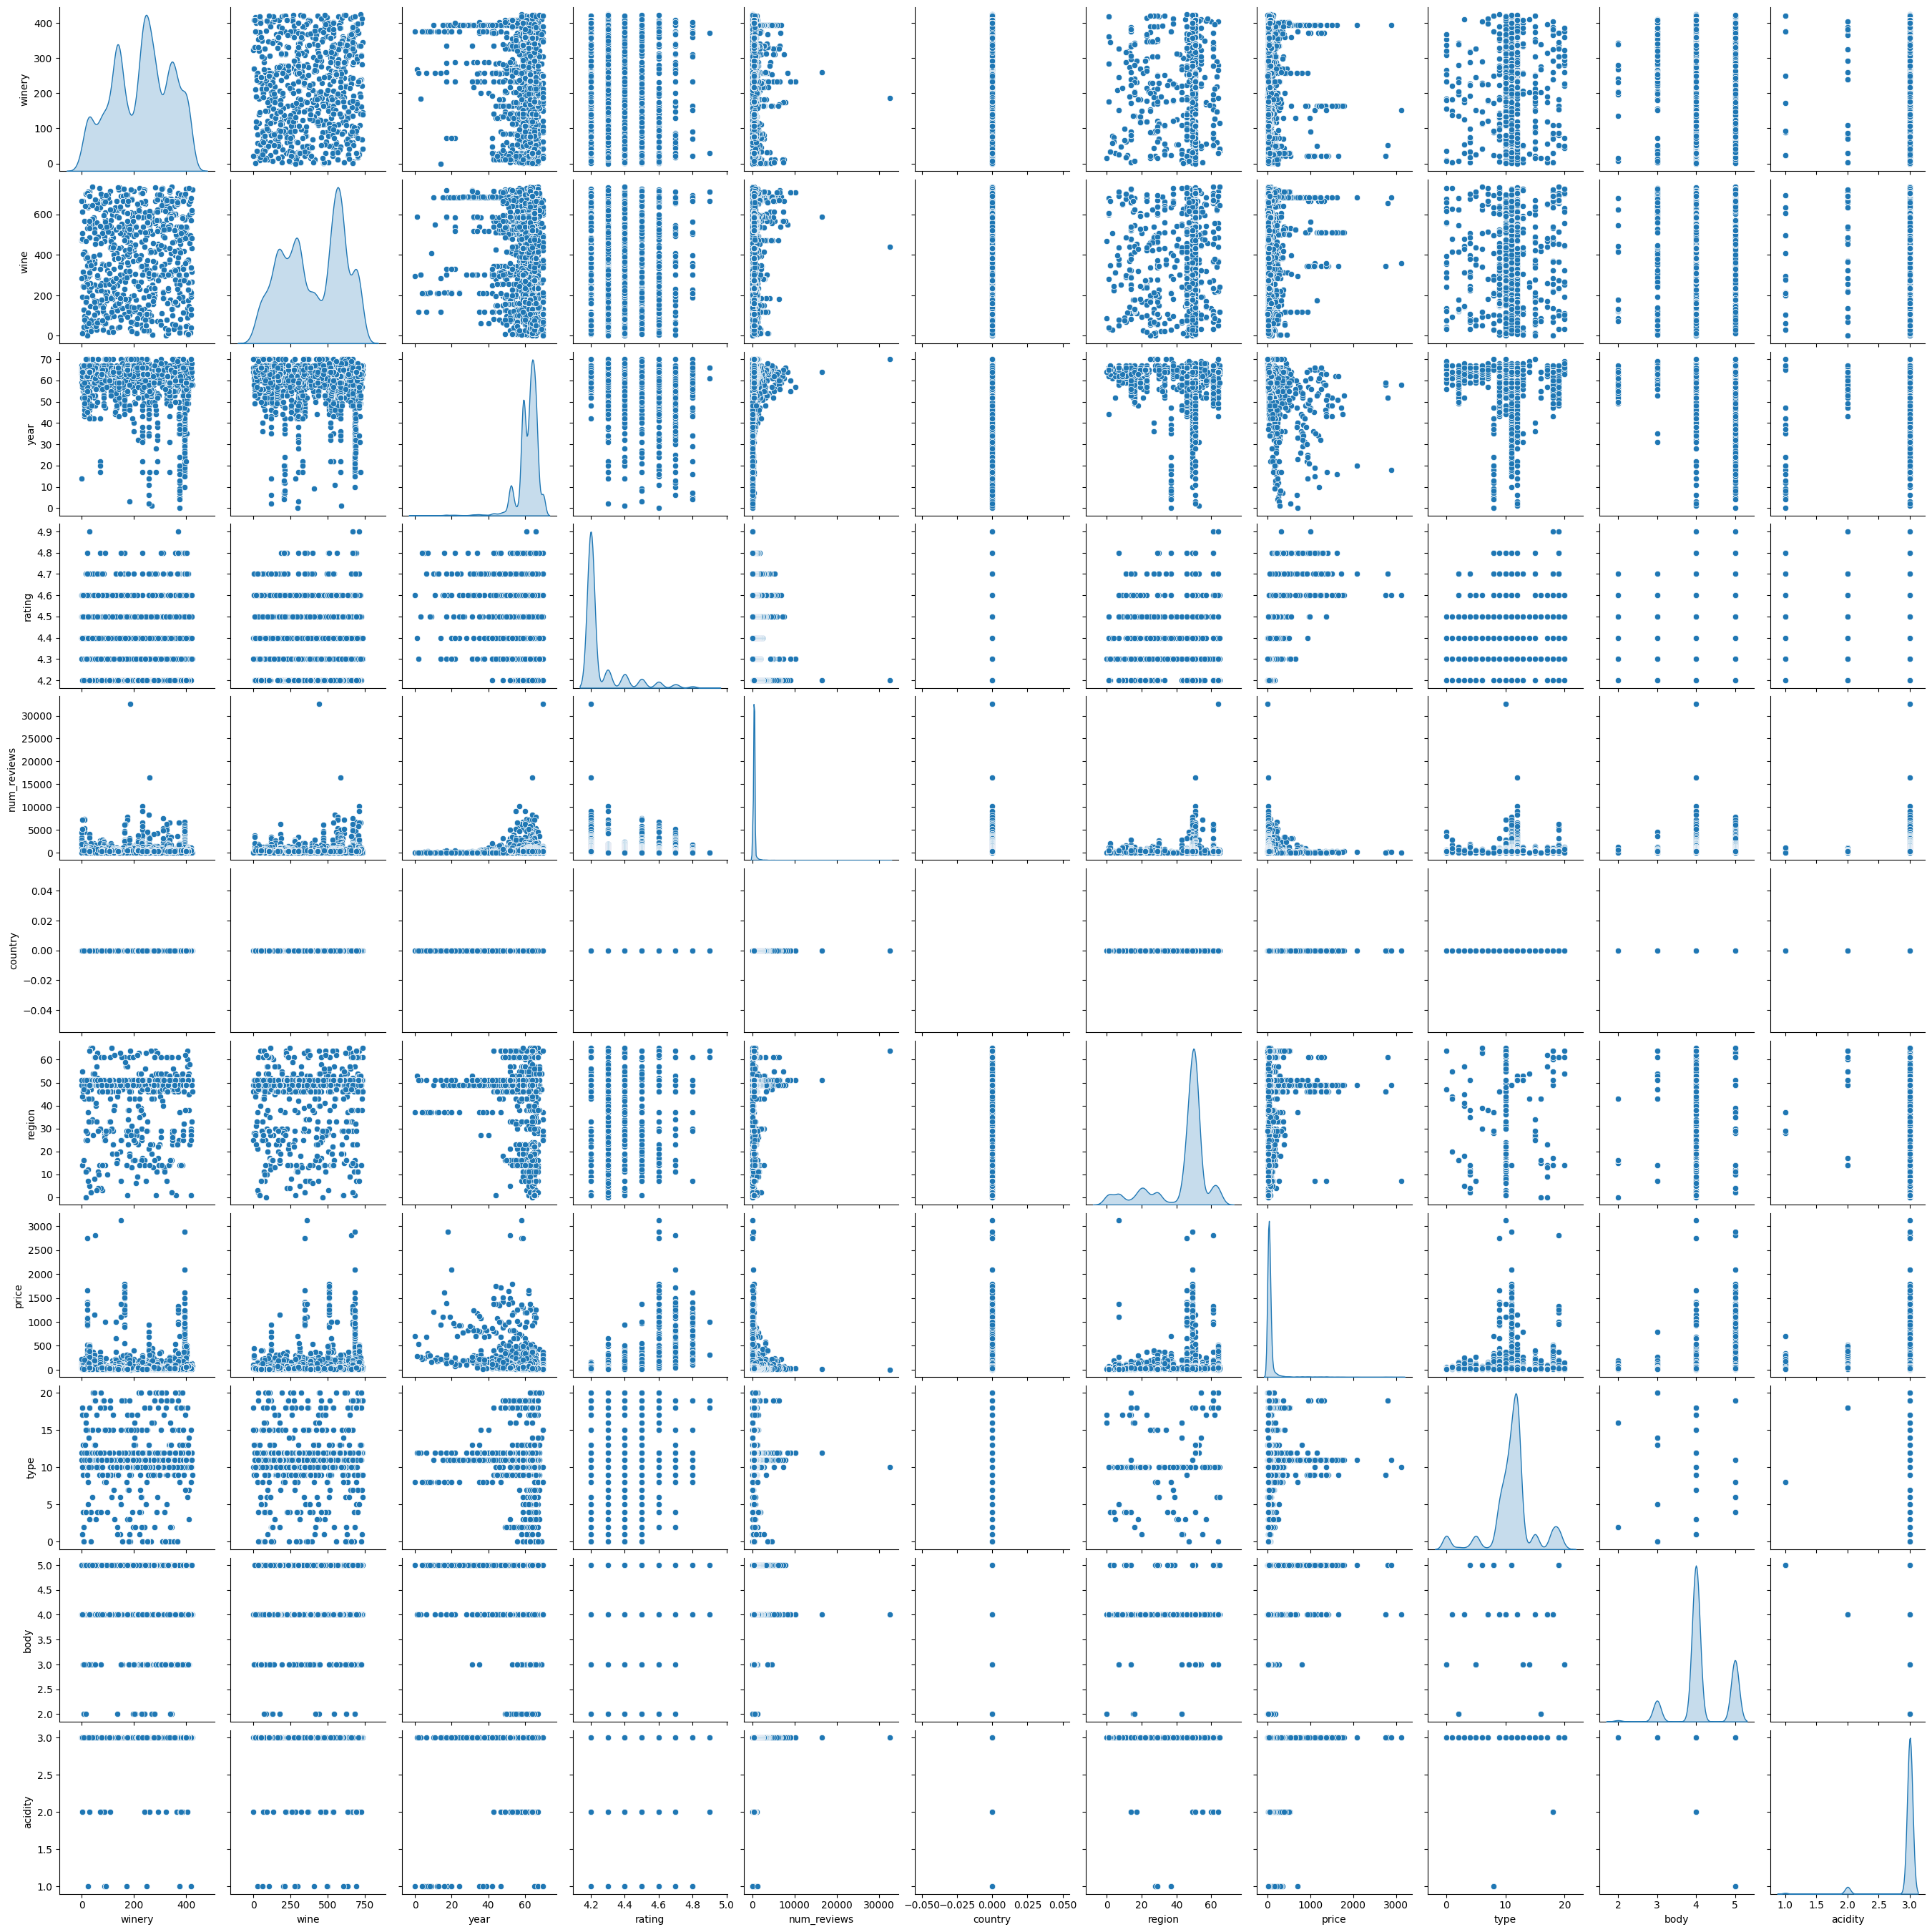

In [9]:
# 4. Visualización de datos
plt.figure(figsize=(8,4))
if 'quality' in df.columns:
    sns.countplot(x='quality', data=df)
    plt.title('Distribución de la calidad del vino')
    plt.show()
sns.pairplot(df, diag_kind='kde')

In [10]:
# 5. Dividir el dataset en entrenamiento y prueba
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    print('Entrenamiento:', X_train.shape, 'Prueba:', X_test.shape)

Entrenamiento: (5063, 10) Prueba: (1266, 10)


In [12]:
# 6. Entrenar un modelo de clasificación
if y is not None:
    # Convertir las etiquetas continuas en clases discretas
    y_train_class = y_train.round().astype(int)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train_class)
    print('Modelo entrenado correctamente')

Modelo entrenado correctamente


In [14]:
# 7. Evaluar el modelo
if y is not None:
    y_pred = model.predict(X_test)
    y_test_class = y_test.round().astype(int)
    print('Accuracy:', accuracy_score(y_test_class, y_pred))
    print('Precision:', precision_score(y_test_class, y_pred, average='weighted'))
    print('Recall:', recall_score(y_test_class, y_pred, average='weighted'))
    print('Matriz de confusión:')
    print(confusion_matrix(y_test_class, y_pred))

Accuracy: 0.9581358609794629
Precision: 0.9543841442057985
Recall: 0.9581358609794629
Matriz de confusión:
[[1165   15]
 [  38   48]]


In [16]:
# 8. Realizar predicciones con nuevos datos
# Ejemplo de predicción con un nuevo vino (modifica los valores según el dataset)
# Debe tener 10 características, en el mismo orden que features.columns
nuevo_vino = np.array([371, 667, 61, 58, 0, 61, 995.00, 19, 5.0, 3.0]).reshape(1, -1)
nuevo_vino_scaled = scaler.transform(nuevo_vino)
if y is not None:
    prediccion = model.predict(nuevo_vino_scaled)
    print('Predicción de calidad para el nuevo vino:', prediccion[0])

Predicción de calidad para el nuevo vino: 5


c:\Users\egusq\C2BCurso\ProyectoFinalC2b2025\Wine-IA-Web\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
